In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
from tqdm.notebook import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Tutorial Normalizing Flows

In questo breve tutorial vedremo come implementare un normalizing flows basato su coupling layers affini ovvero le trasformazioni biiettive utilizzata nel [RealNVP](https://arxiv.org/pdf/1605.08803.pdf).

Riprendiamo la base formale dei Normalizing Flows:

$$\begin{align*}
\log q(\mathbf{x}) &= \log q_0(\mathbf{z}) + \log \left| \frac{\partial \mathbf{z}}{\partial \mathbf{x}} \right| \\
\mathbf{z} &= f(\mathbf{x})
\end{align*}
$$

## Dataset

Il dataset "half moons" pur essendo molto semplice ci permetterà di visualizzare come funziona il normalizing flow.

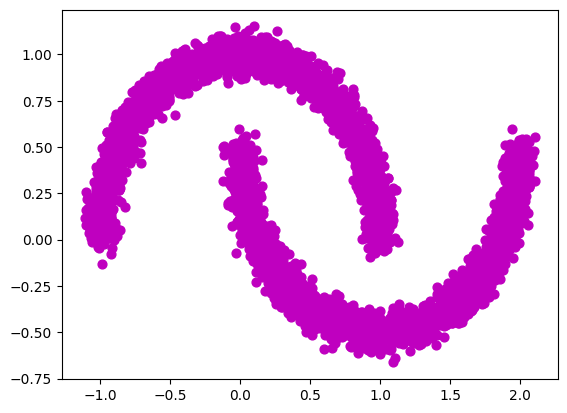

In [3]:
num_samples = 5000

X, _ = sklearn.datasets.make_moons(num_samples, noise=0.05)

X_val, _= sklearn.datasets.make_moons(num_samples//3, noise=0.05)

plt.scatter(X.T[0], X.T[1], s=40, c='m')

num_features = X.shape[-1]

In [4]:
batch_size=256
train_loader = torch.utils.data.DataLoader(torch.tensor(X), batch_size=batch_size, shuffle=True) #Il dataloader e' una classe di pytorch molto utile per gestire i minibatch durante gli addestramenti

## Affine Coupling Layer

Il coupling layer affine divide in due insiemi il dato, un 
insieme viene rimane invariato mentre l'altro viene trasformato attraverso una funzione affine i quali parametri vengono fissati da due reti neurali (s e t): 

\begin{align*}
y_A &= x_A \\
y_B &= e^{s(x_A)} \odot x_B + t(x_A)
\end{align*}

$$\log \left| \frac{\partial \mathbf{y}}{\partial \mathbf{x}} \right| = \sum_{i=1}^{D_B} s_i(\mathbf{x}_A)$$


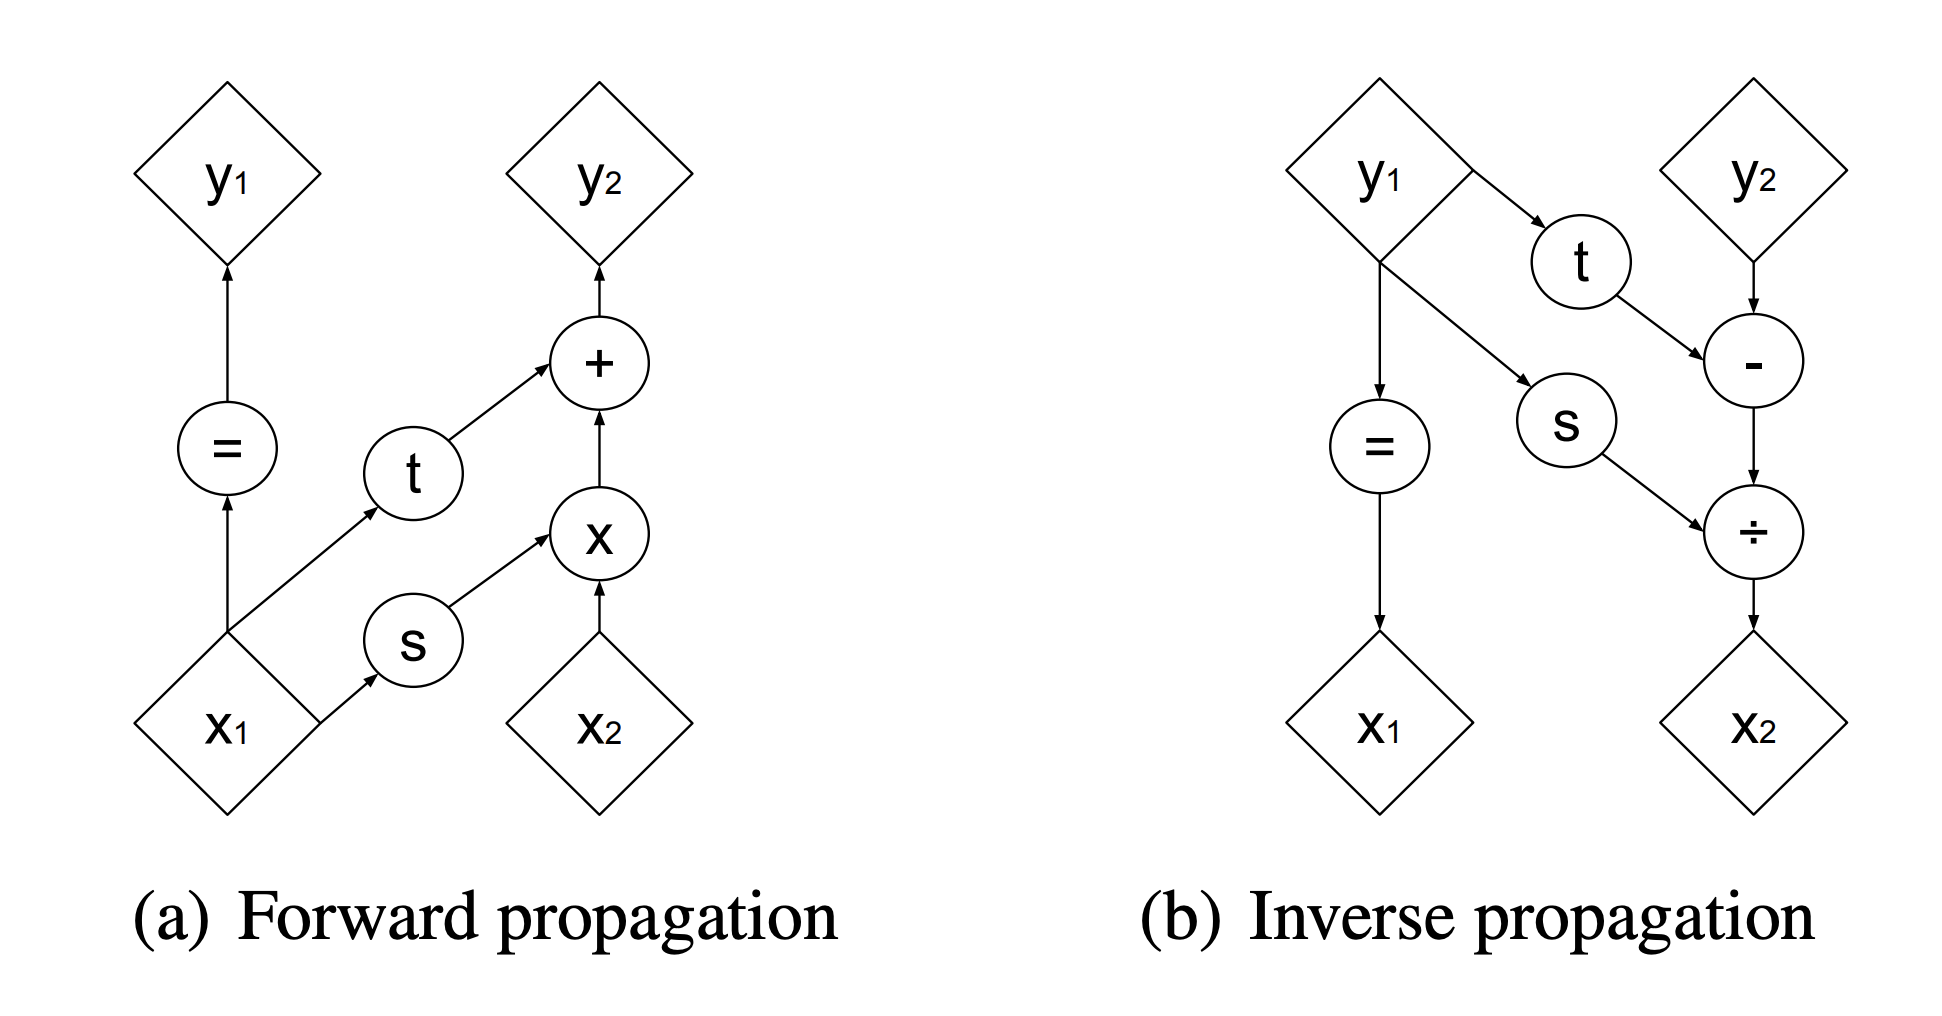

Contrariamente a come lascia intendere la teoria, nei coupling layer il dato non viene letteralmente separato in due insiemi ma viene "mascherato" usando delle maschere binarie prima di essere mandato in input alle reti.

Un discorso simile vale per le reti neurali, non useremo due reti neurali ma una soltanto con output uguale a due volte le features in input. L'output viene poi separato in due "canali" e mascherato con la maschera inversa.

In [5]:
def make_checker_mask(shape, parity,device):
    checker = torch.ones(shape, dtype=torch.uint8).to(device)
    checker[::2] = parity
    checker[1::2] = 1-parity
    return checker

In [6]:
make_checker_mask(10,0,device)

tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0', dtype=torch.uint8)

In [7]:
make_checker_mask(10,1,device)

tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0', dtype=torch.uint8)

Al coupling layer accoppieremo dei semplici MLPs.

In [8]:
def make_linear_net(hidden_sizes, input_shape,device='cuda'):
    '''
    Multi-layer perceptron
    hiddens_sizes=[N_neurons for hidden layer 1, .... ,N_neurons for hidden layer n]
    num hidden layers = len(hidden_sizes)

    semplice rete neurale MLP con Leaky ReLU come attivazioni degli hidden layer e nessuna attivazione in output.
    '''
    sizes = [input_shape] + hidden_sizes + [input_shape*2]
    net = []
    for i in range(len(sizes) - 1):
        net.append(torch.nn.Linear(sizes[i], sizes[i+1], dtype=torch.double, device=device))
        if i!=(len(sizes)-2):
            net.append(torch.nn.LeakyReLU(0.1))
    torch.nn.init.zeros_(net[-1].weight) #Inizializzando i parametri dell'ultimo layer inizializzeremo il NF con l'identità
    return torch.nn.Sequential(*net)

Modulo per il coupling layer affine, gli input al costruttore sono:
* una rete neurale che prende in input il dato mascherato e restituisce in output due volte il numero di features dell'input. L'output viene poi separato in due 'canali' (uno per lo shift s e uno per lo scaling m) e maskerato.
* maschera

In [19]:
class AffineCouplingLayer(torch.nn.Module):

    def __init__(self, network, mask):
        super().__init__()
        self.network = network
        self.mask=mask

    def forward(self, z, ldj, reverse=False):

        z_in = z * self.mask  #mascheriamo l'input
        nn_out = self.network(z_in).reshape(-1,2,z.shape[-1])  #lo mandiamo in input alla rete neurale
        s, t = nn_out[:,0], nn_out[:,1] #l'output viene poi separato in s (scaling) e m (shifting)

        s = torch.tanh(s)  #applichiamo una tangente iperbolica allo scaling per evitare instabilita' numeriche
        

        s = s * (1 - self.mask)  #mascheriamo i parametri
        t = t * (1 - self.mask)

        # Trasformazione affine
        if not reverse:
            z = (z + t) * torch.exp(s)  
            ldj += s.sum(dim=[1])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1])

        return z, ldj

In [10]:
#Semplice funzione per costruire il normalizing flows
def make_NF(n_cl,hidden_sizes,input_shape,device):
    layers = []
    for i in range(n_cl):
        parity = i % 2
        net= make_linear_net(hidden_sizes, num_features,device)
        mask=make_checker_mask(input_shape,parity,device)
        layers.append(AffineCouplingLayer(net,mask))
    return torch.nn.ModuleList(layers)    

## Flows

Per gestire al meglio tutto ciò che possono fare i flow (stimare la likelihood, generare, ...) implementiamo una classe apposita. 

In [11]:
#Classe per gestire al meglio forward e reverse del modello
class Flow(torch.nn.Module):
    def __init__(self, input_shape, n_cl, hidden_sizes, device='cpu'):
        super().__init__()
        self.input_shape=input_shape
        self.prior= torch.distributions.normal.Normal(loc=0.0, scale=1.0) #In questo tutorial fissiamo la distribuzione base ad essere una Normale con media nulla e covarianza identita'
        self.flows=make_NF(n_cl,hidden_sizes,input_shape,device)
        self.device=device
    #questa funzione mappa il dato nella distribuzione base
    def f(self, x):
        z, ldj = x, torch.zeros(x.shape[0], device=self.device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj
    #Calcolo della loss
    def _get_likelihood(self,x):
        z, ldj = self.f(x)
        log_pz = self.prior.log_prob(z).sum(-1)
        log_px = ldj + log_pz
        return -log_px.mean()
    #Questa funzione serve a pytorch per capire qual'e' il "grafo" sul quale eseguire la backpropagation
    def forward(self,x):
        return self._get_likelihood(x)

    #Funzione per generare i dati una volta che il NF e' addestrato    
    @torch.no_grad() #Questo comando serve per indicare a pytorch che questa funzione non deve essere differenziata, si risparmia cosi' molta memoria
    def g(self, batch_size, save_hs=False):
        z =self.prior.sample(sample_shape=(batch_size,self.input_shape)).to(self.device).double()
        ldj = torch.zeros(batch_size, device=self.device)
        hs=z.unsqueeze(0)
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
            if save_hs:
              hs=torch.cat((hs,z.unsqueeze(0)),dim=0)
        return z, hs
        

L'ultima cosa che rimane da implementare è una funzione per addestrare il flow, chiamiamo "epoche" un ciclo in cui l'ottimizzatore ha visto tutti i campioni del dataset. Per controllare se il modello sta overfittando, dopo ogni epoca calcoliamo la likelihood sul validation set.

In [12]:
#Funzione per il training
def training(flow,optimizer, train_loader, X_val, epochs,device='cpu'):
    history={'loss':[],'val_loss':[]}
    for j in tqdm(range(epochs)):  #Cicliamo sulle epoche
        running_loss = []
        for data in train_loader:  #cicliamo sui minibatch
            optimizer.zero_grad()   #sintassi di Pytorch
            loss= flow(data.to(device))  #Calcoliamo la loss
            loss.backward()   #calcoliamo i gradienti
            optimizer.step()   #aggiorniamo l'ottimizzatore
            running_loss.append(loss.item())  
        history['loss'].append(np.asarray(running_loss).mean())
        with torch.no_grad():
            val_loss=flow(torch.tensor(X_val).to(device)).item()
        history['val_loss'].append(val_loss)
        print('Epoch {} Loss: {:.4f} Val Loss: {:.4f}'.format(j+1, history['loss'][-1], history['val_loss'][-1]))  
    return history


## Addestramento del modello

Abbiamo ora tutti gli ingredienti per addestrare un Normalizing Flows:

In [20]:
input_shape=num_features
hidden_sizes=[100,100,100]
ncl=24
flow=Flow(input_shape, ncl,hidden_sizes,device)

In [21]:
optimizer = torch.optim.Adam(flow.flows.parameters(), lr=0.001, weight_decay=0.001)

In [22]:
epochs=150

In [23]:
history=training(flow,optimizer,train_loader,X_val, epochs,device)

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1 Loss: 2.0062 Val Loss: 1.7798
Epoch 2 Loss: 1.6865 Val Loss: 1.6199
Epoch 3 Loss: 1.5290 Val Loss: 1.4997
Epoch 4 Loss: 1.4028 Val Loss: 1.3231
Epoch 5 Loss: 1.2247 Val Loss: 1.1154
Epoch 6 Loss: 1.1779 Val Loss: 1.1470
Epoch 7 Loss: 1.0136 Val Loss: 0.9258
Epoch 8 Loss: 0.8801 Val Loss: 0.9688
Epoch 9 Loss: 0.7910 Val Loss: 0.6845
Epoch 10 Loss: 0.5793 Val Loss: 0.5304
Epoch 11 Loss: 0.5049 Val Loss: 0.6228
Epoch 12 Loss: 0.5176 Val Loss: 0.5113
Epoch 13 Loss: 0.5379 Val Loss: 0.4882
Epoch 14 Loss: 0.4894 Val Loss: 0.5030
Epoch 15 Loss: 0.5034 Val Loss: 0.4206
Epoch 16 Loss: 0.4104 Val Loss: 0.4329
Epoch 17 Loss: 0.4425 Val Loss: 0.4110
Epoch 18 Loss: 0.4213 Val Loss: 0.4416
Epoch 19 Loss: 0.4070 Val Loss: 0.4660
Epoch 20 Loss: 0.4028 Val Loss: 0.4332
Epoch 21 Loss: 0.4061 Val Loss: 0.3876
Epoch 22 Loss: 0.4193 Val Loss: 0.4003
Epoch 23 Loss: 0.4077 Val Loss: 0.3799
Epoch 24 Loss: 0.3778 Val Loss: 0.4102
Epoch 25 Loss: 0.3920 Val Loss: 0.3976
Epoch 26 Loss: 0.3940 Val Loss: 0.

Plot delle curve di learning:

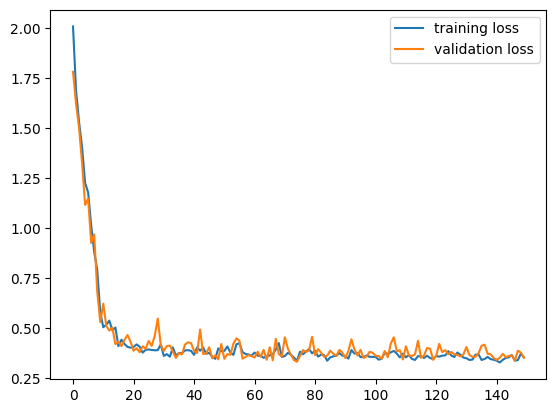

In [24]:
plt.plot(history['loss'],label='training loss')
plt.plot(history['val_loss'],label='validation loss')
plt.legend()
plt.show()

## Test del modello

Siccome abbiamo un dataset molto semplice da visualizzare, possiamo stampare il dataset X e la distribuzione latente Z=f(X) (plot rossi). A questo punto generiamo delle nuove gaussiane $\hat{Z}$ e le traformiamo in dati sintetici: $\hat{X}=f^{-1}(\hat{Z})$ (plot verdi).

[Text(0.5, 1.0, 'Generated data space X'), None, Text(0, 0.5, 'y')]

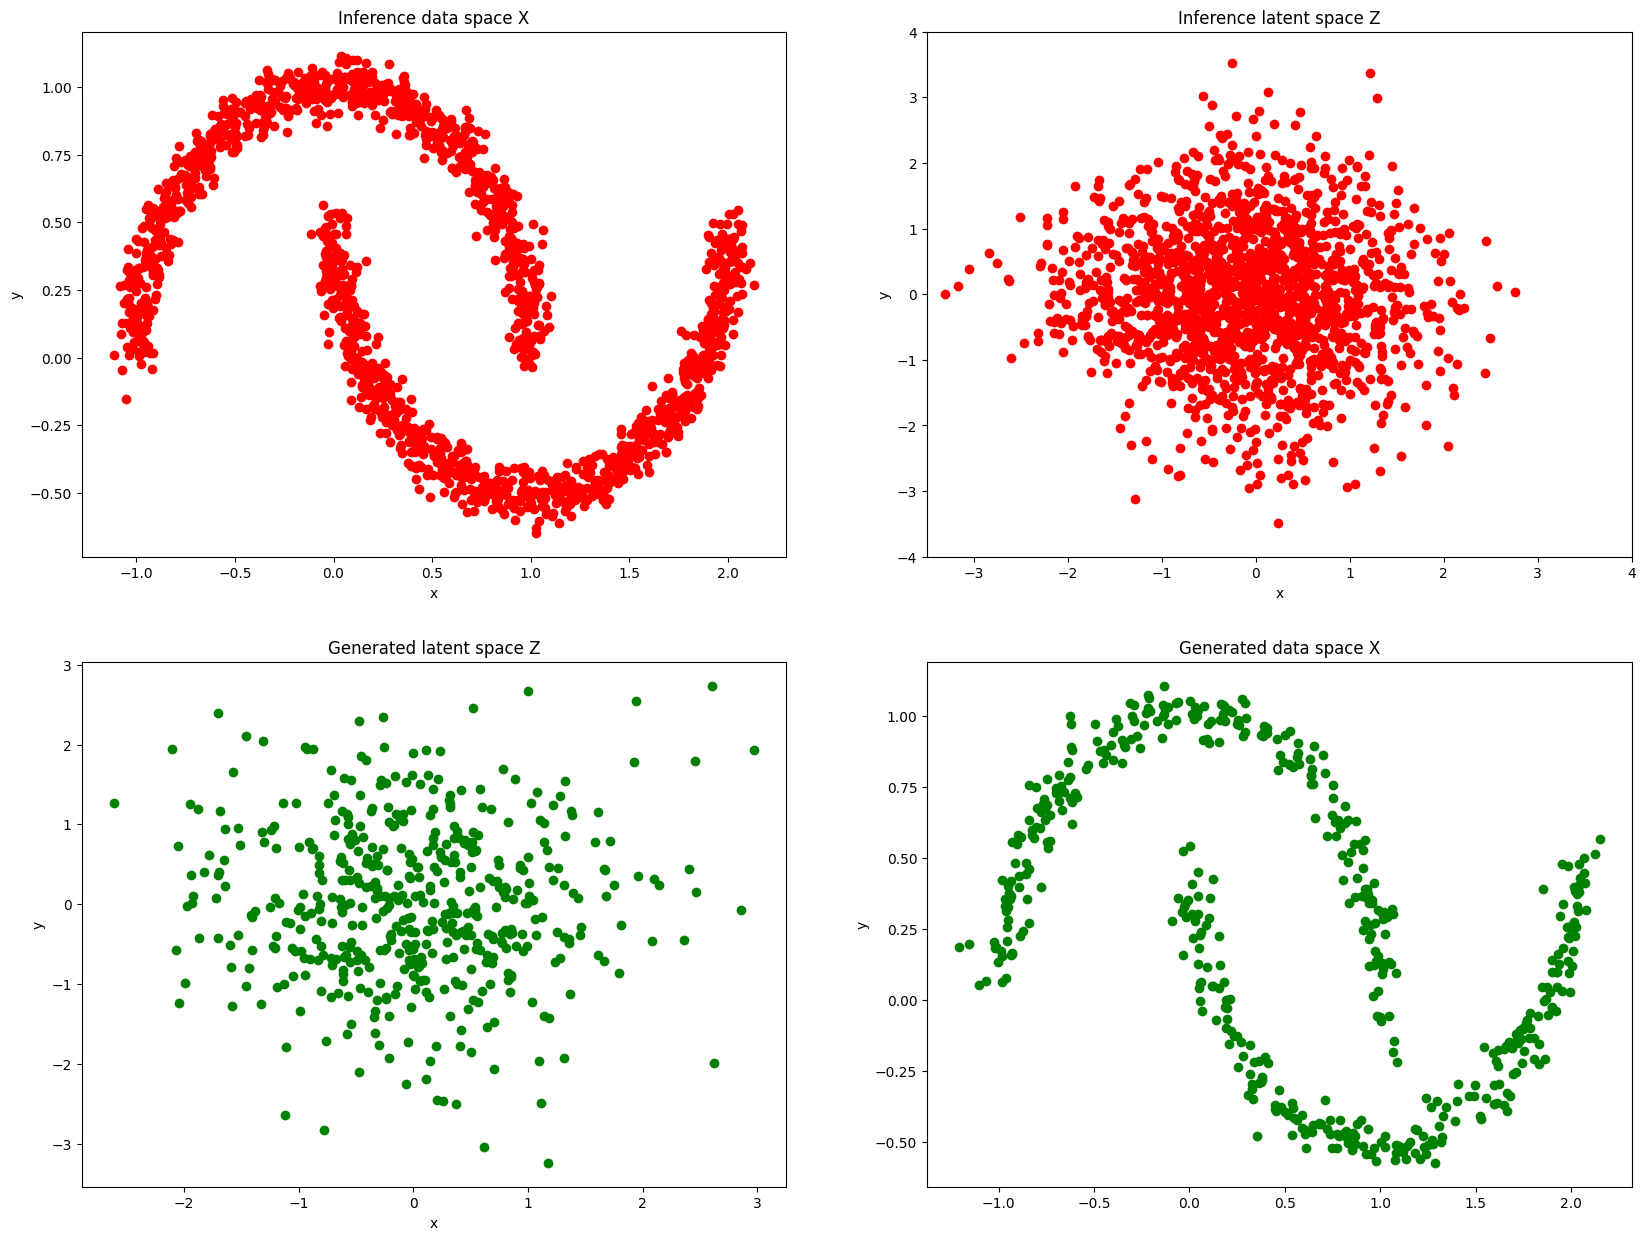

In [25]:
with torch.no_grad(): 
    z_hat,_=flow.f(torch.tensor(X_val).to(device))
x_hat,z=flow.g(500,False)
f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(X_val[:, 0], X_val[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z_hat[:, 0].cpu(), z_hat[:, 1].cpu(), color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(z[:,:, 0].cpu(), z[:,:, 1].cpu(), color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x_hat[:, 0].cpu(), x_hat[:, 1].cpu(), color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")

Per capire meglio come funziona il modello possiamo studiare come evolve la rappresentazione lungo il flusso del NF:

In [26]:
x_hat,z=flow.g(250,True)

Dati gaussiani in input al generatore:

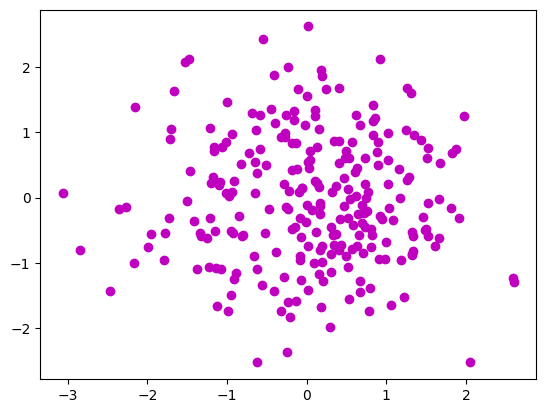

In [27]:
plt.scatter(z[0,:,0].cpu(),z[0,:,1].cpu(), color="m")

Stampiamo ora i dati ogni due coupling layers:

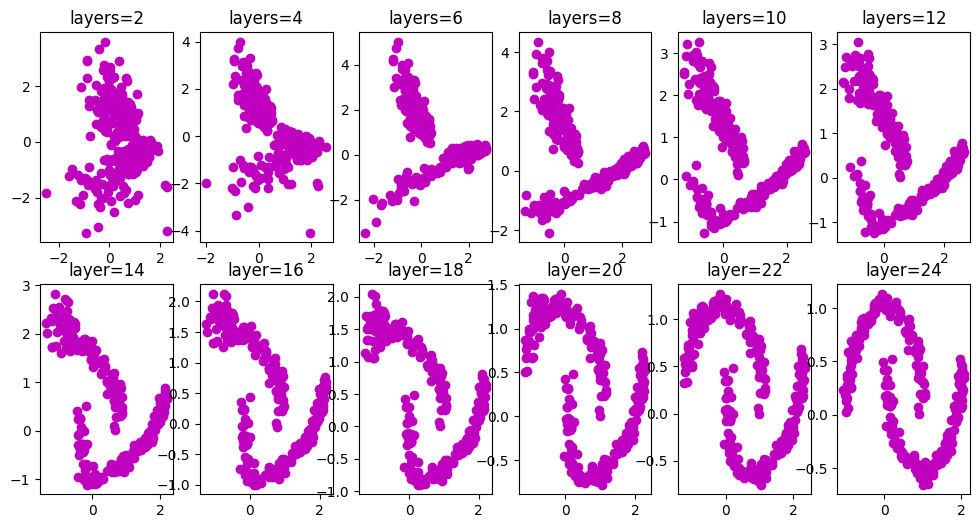

In [28]:
f, axes = plt.subplots(2, 6, figsize=(12, 6))
idx=np.arange(2,14,2)
idx2=np.arange(14,26,2)
for i in range(len(idx)): 
    axes[0,i].scatter(z[idx[i],:,0].cpu(),z[idx[i],:,1].cpu(), color="m")
    axes[0,i].set(title="layers="+str(idx[i]))
for i in range(len(idx2)): 
    axes[1,i].scatter(z[idx2[i],:,0].cpu(),z[idx2[i],:,1].cpu(), color="m")
    axes[1,i].set(title="layer="+str(idx2[i]))